In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import path
import matplotlib.patches as patches
from skimage import draw
import scipy.ndimage as ndimage
import Utils
import georasters as gr
import cv2
from Utils import doubleMADsfromMedian
from skimage.transform import resize
import pickle
import simplekml
import geopandas

def order_rect(List_P_strings, top_bottom = False):
    #If top_bottom is false then sort right left
    if not top_bottom:
        List_P_strings = [[(List_P[0][1],List_P[0][0]),
                           (List_P[1][1],List_P[1][0]),
                           (List_P[2][1],List_P[2][0]),
                           (List_P[3][1],List_P[3][0])] for List_P in List_P_strings]
    
    bboxes=sorted(List_P_strings, key=lambda x: x[0][0])
    bboxes = [(P[0][0], P[0][1], P[2][0]-P[0][0], P[2][1]-P[0][1]) for P in bboxes]
    df=pd.DataFrame(bboxes, columns=['x','y','w', 'h'], dtype=int)
    

    df["x2"] = df["x"]+df["w"] # adding column for x on the right side
    df = df.sort_values(["x","y", "x2"]) # sorting


    for i in range(2): # change rows between each other by their coordinates several times 
    # to sort them completely 
        for ind in range(len(df)-1):
        #     print(ind, df.iloc[ind][4] > df.iloc[ind+1][0])
             if df.iloc[ind][4] > df.iloc[ind+1][0] and df.iloc[ind][1]> df.iloc[ind+1][1]:
                df.iloc[ind], df.iloc[ind+1] = df.iloc[ind+1].copy(), df.iloc[ind].copy()
            
    L_F = [np.array([[box[0], box[1]], 
               [box[0] + box[2], box[1]], 
               [box[0] + box[2], box[1] + box[3]], 
               [box[0], box[1] + box[3]]]) for box in df.values.tolist()]
    
    if not top_bottom:
        L_F = [[(List_P[0][1],List_P[0][0]),
                           (List_P[1][1],List_P[1][0]),
                           (List_P[2][1],List_P[2][0]),
                           (List_P[3][1],List_P[3][0])] for List_P in L_F]
    return np.array(L_F) 

/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# Parameters

In [92]:
#path_T = "Thermo.tif"
#path_String = "Thermo_String_PV01.tif"

path_T = "Los_Loros/TH_02_index_thermal_ir.tif"
path_Mesa_shape = "Los_Loros/Mesas.shp"
#path_String = "Los_Loros/Raster_Test.tif"
ZonaPV = 'Test'
path_kml_panel = 'Los_Loros/KML/Paneles_' + ZonaPV +'.kml'
path_kml_mesa ='Los_Loros/KML/Mesa_' + ZonaPV +'.kml'
path_dict = 'Los_Loros/KML/Mesa_' + ZonaPV + '.pickle'

#panel_size = (11 , 21)
#panel_size = (37 , 17) #weight, height size#
#panel_size = (20 , 35)

split_Weight, split_Height = (10,2)
overlap = 0
order_top_bottom = False # order top bottom or right left


GR_T = gr.from_file(path_T)
geot = GR_T.geot
GR_T.raster.data[GR_T.raster.data == -10000] = 0

# Enumerate Tables and Panels

In [93]:
# If Mesas is Raster
""""
label_im, nb_labels = ndimage.label(GR_String.raster.data > 0)#, structure= np.ones((2,2))) ## Label each connect region

        
L_strings = {} # {name: '001', points:(top-left, top-right, bottom-right, bottom-left) (x,y), 'panels' : }

epsilon = 0

List_P_strings = []
for i in range(1, nb_labels + 1):
    
    countours, hierarchy = cv2.findContours(np.uint8(label_im == i), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x_max = np.max(countours[0][:, 0, 0]) + epsilon
    y_max = np.max(countours[0][:, 0, 1]) + epsilon
    x_min = np.min(countours[0][:, 0, 0]) - epsilon
    y_min = np.min(countours[0][:, 0, 1]) - epsilon
    
    List_P_strings.append([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])
    
"""

'"\nlabel_im, nb_labels = ndimage.label(GR_String.raster.data > 0)#, structure= np.ones((2,2))) ## Label each connect region\n\n        \nL_strings = {} # {name: \'001\', points:(top-left, top-right, bottom-right, bottom-left) (x,y), \'panels\' : }\n\nepsilon = 0\n\nList_P_strings = []\nfor i in range(1, nb_labels + 1):\n    \n    countours, hierarchy = cv2.findContours(np.uint8(label_im == i), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)\n    x_max = np.max(countours[0][:, 0, 0]) + epsilon\n    y_max = np.max(countours[0][:, 0, 1]) + epsilon\n    x_min = np.min(countours[0][:, 0, 0]) - epsilon\n    y_min = np.min(countours[0][:, 0, 1]) - epsilon\n    \n    List_P_strings.append([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])\n    \n'

In [94]:
## If mesas is Shape

df = geopandas.read_file(path_Mesa_shape)
G = [i for i in df.geometry]
List_P_strings = []

for g in G: 
    x,y = g.exterior.coords.xy
    coords = np.dstack((x,y)).tolist()[0][:-1]
    List_P_strings.append(Utils.gps2pixel(np.array(coords), geot))

In [95]:

L_strings = {}
    
for i,List_P in enumerate(order_rect(List_P_strings, top_bottom=order_top_bottom), 1):
    
    L_strings[str(i)] = {'id': i, 
                         'points' : List_P, 
                         'panels' : {}, 
                         'status': 'default', 
                         'T': np.mean(GR_T.raster.data[List_P[0][1]:List_P[2][1],List_P[0][0]:List_P[2][0]])}

for string_key in L_strings.keys():
    
    string = L_strings[string_key]
    string['panels'] = {}
    Points = Utils.order_points_rect(string['points']).astype(np.int)
    
    ## If strings is vertical or horizontal
    #if (Points[2][0] - Points[0][0]) > (Points[2][1] - Points[0][1]):
    #    split_Weight, split_Height = np.int((Points[2][0] - Points[0][0]) / panel_size[0]) , np.int((Points[2][1] - Points[0][1]) / panel_size[1])
    #else:
    #    split_Weight, split_Height = np.int((Points[2][0] - Points[0][0]) / panel_size[1]) , np.int((Points[2][1] - Points[0][1]) / panel_size[0])

    #split_Weight = max(split_Weight, 1)
    #split_Height = max(split_Height, 1)
    M, maxWidth, maxHeight = Utils.perspectiveTransform(Points)
    sub_division = Utils.subdivision_rect([split_Weight, split_Height], maxWidth, maxHeight, overlap)
    sub_division_origin = np.uint(cv2.perspectiveTransform(np.array(sub_division), np.linalg.inv(M)))
    
    for i,panels_coord in enumerate(order_rect(sub_division_origin, order_top_bottom),1):
        string['panels'][str(i)] = {'id' : i,
                                    'points' : panels_coord,
                                    'status': 'default', 
                                    'T' : np.mean(GR_T.raster.data[panels_coord[0][1]:panels_coord[2][1], panels_coord[0][0]:panels_coord[2][0]]),
                                    'severidad': 'default'}    


# Save dictionary with gps data

In [96]:
## Save List in coordinate latitud and longitude ###

L_strings_coord = {}
           
for string_key in L_strings.keys():
    
    string = L_strings[string_key]
    points = string['points']
    string_coord = {'id': 'Mesa_' + str(string['id']).zfill(3), 
                    'points': Utils.pixel2gps(points, geot), 
                    'panels': {}, 
                    'status': string['status'], 
                    'T' : string['T']}
    
    for panel_key in string['panels'].keys():
           
        panel = string['panels'][panel_key]
        points = panel['points']
        panel_coord = {'id': panel['id'],
                       'points': Utils.pixel2gps(points, geot), 
                       'status': panel['status'], 
                       'prob': 0.0, 
                       'T': panel['T'],  
                       'severidad': 'default'}
        
        string_coord['panels'][panel_key] = panel_coord
        
    L_strings_coord[string_key] = string_coord



# Display image

<Figure size 432x288 with 0 Axes>

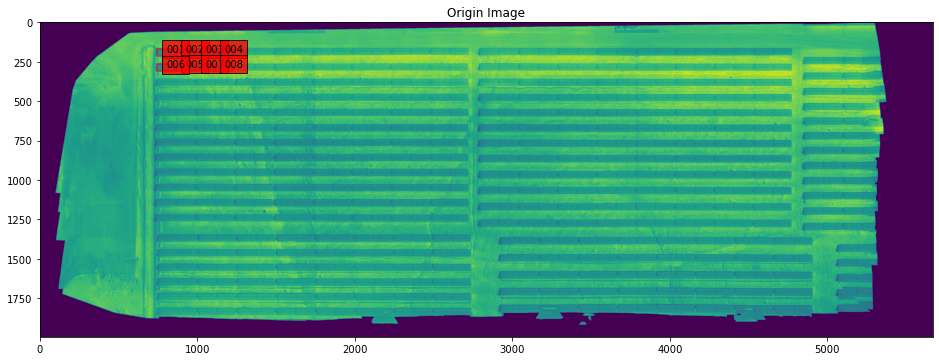

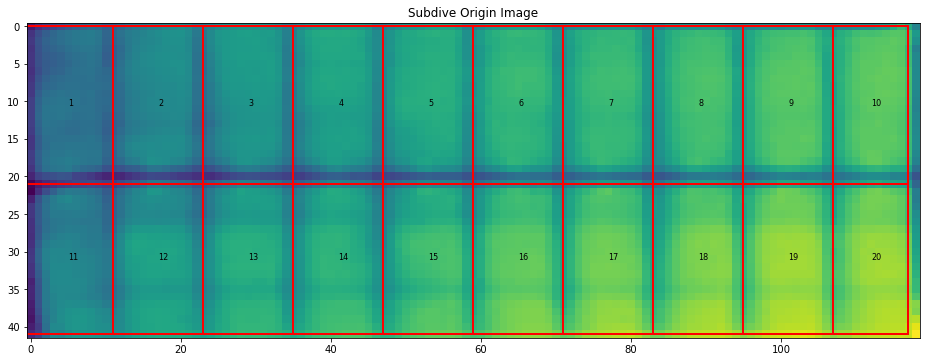

In [102]:
## Load List in coordinate latitud and longitude  to pixels ###
string = L_strings_coord['6']
panels = string['panels']


epsilon = 0
matrix_expand_bounds = [[-epsilon, -epsilon],[+epsilon, -epsilon], [+epsilon, +epsilon], [-epsilon, +epsilon]]

#geot = GR_RGB.geot
geot = GR_T.geot



Points = Utils.gps2pixel(string['points'], geot) + matrix_expand_bounds



plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(GR_T.raster.data)
plt.title('Origin Image')
ax = plt.gca()

for Poly_key in L_strings_coord.keys():
    
    Poly = L_strings_coord[Poly_key]
    poly = patches.Polygon(Utils.gps2pixel(Poly['points'],geot),
                     linewidth=2,
                     edgecolor='red',
                     alpha=0.5,
                     fill = True)
    plt.text(np.mean([x[0]  for x in Utils.gps2pixel(Poly['points'],geot)]), 
             np.mean([y[1]  for y in Utils.gps2pixel(Poly['points'],geot)]) , 
             str(Poly['id']).split('_')[-1],  bbox=dict(facecolor='red', alpha=0.8), fontsize=10)

    ax.add_patch(poly)
    
plt.figure(1)
plt.figure(figsize=(16, 16))
#plt.imshow(GR_T.raster[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]])
plt.imshow(GR_T.raster[Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]])
#plt.imshow((GR_RGB.raster[:3,:,:]).transpose((1, 2, 0))[Points[0][1] : Points[2][1], Points[0][0]: Points[2][0],:])

plt.title('Subdive Origin Image')
ax = plt.gca()

for Poly_key in panels.keys():
    
    Poly = panels[Poly_key]
    poly = patches.Polygon(Utils.gps2pixel(Poly['points'],geot) - (Points[0][0], Points[0][1]),
                     linewidth=2,
                     edgecolor='red',
                     fill = False)
    plt.text(np.mean([x[0]  for x in Utils.gps2pixel(Poly['points'],geot) - (Points[0][0], Points[0][1])]), np.mean([y[1]  for y in Utils.gps2pixel(Poly['points'],geot) - (Points[0][0], Points[0][1])]) , 
             str(Poly['id']),  bbox=dict(facecolor='red', alpha=0.0), fontsize=8)

    ax.add_patch(poly)

# Save KML

In [98]:

## Save List in coordinate latitud and longitude ###
with open(path_dict, 'wb') as handle:
    pickle.dump(L_strings_coord, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Load List in coordinate latitud and longitude ###
with open(path_dict, "rb") as fp:
    L_strings_coord = pickle.load(fp)

kml=simplekml.Kml()


for string_key in L_strings_coord.keys():
    
    string = L_strings_coord[string_key]
    points = string['points']
    
    pmt = kml.newpolygon(name= string['id'], 
                         outerboundaryis = points)
    pmt.extendeddata.newdata(name='Mesa', value=string['id'])
    pmt.extendeddata.newdata(name= 'T°', value= string['T'])
    
kml.save(path_kml_mesa)


kml=simplekml.Kml()


for string_key in L_strings_coord.keys():
    
    string = L_strings_coord[string_key]
    points = string['points']
    
    for panel_key in string['panels'].keys():
        panel = string['panels'][panel_key]
        points = panel['points']
        
        pmt = kml.newpolygon(outerboundaryis = points)
        pmt.extendeddata.newdata(name= 'Id integer', value= str(string_key).zfill(3) + '_' + str(panel['id']).zfill(3))
        pmt.extendeddata.newdata(name= 'Id panel', value= str(panel['id']).zfill(3))
        pmt.extendeddata.newdata(name='Zona PV', value= ZonaPV)
        pmt.extendeddata.newdata(name='Cód. Fall', value= 0)
        pmt.extendeddata.newdata(name= 'Tipo falla', value= panel['status'])
        pmt.extendeddata.newdata(name= 'Mesa', value= string['id'])
        pmt.extendeddata.newdata(name= 'T°', value= panel['T'])
        
kml.save(path_kml_panel)
print('Listo')

Listo
